# Questionnaire data processing of the Collective Memory Project.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from data_process import MAJOR_HISTORICAL_FLOODS, water_level, get_actual_levee_height, W_MIN, W_MAX, stats_fre_questionnaris
%matplotlib inline

In [2]:
questionnaire = pd.read_csv("data/CM_data.csv", parse_dates=['submit_time'], index_col=['id'], encoding='gbk')

## Clean data

### Aims:

- Sort data dtpyes.
- Transmit language into English.
- Judge which questionnaires are invalid.
- Processing missing or duplicated data.

#### Mission 1: Missing values
We drop columns whose missing value over a threshold of 80% and all duplicated records.


#### Mission 2: Sort dtypes.

data dictionary:
- submit_time: questionnaires' submit time. Howerver, submit time of offline questionnaires indicates the time enterred into computer.
- location: address of the respondent. city > county > district
- men, women: different number of family members of each gender.
- 1_14, 15_24...65+: age structure of family members.
- education: the highest education level of the family
- farm: farmer or not farmer
- income: annual income (Chinese Yuan)
- message(1946, 1964, 1981, 2012): mode of communicating in each flooding year
- trans(1946, 1964, 1981, 2012): mode of transport in each flooding year
- insurance: purchased insurance or not
- experience: never experienced, infundation, flooding, or both
- 1904, 1946, 1964, 1981, 2012: how can respondent recall each historical flooding event.
- levee: How does respondent believe the levee can avoid them from the risk of flooding? 0: Do not believe absolutly; 10: Believe.
- report: How does respondent believe the report the flood risk? 0: Do not trust absolutly; 10: Trust absolutly.
- maner: How does respondent believe the government can manage flooding risks? 0: Do not believe government absolutly; 10: Believe.

In [3]:
# exploring the value_counts and missing values of a series.
def explore_sorted_counts(ser, show_all=False):
    missing = ser.isnull().sum() / len(ser)
    data = ser.value_counts(dropna=False).sort_values(ascending=False)
    if not show_all:
        if len(data) > 10:
            length = len(ser.unique())
            print(data.head(10), "\n......total {} unique values......\n".format(length))
        else:
            print(data, '\n')
    else:
        print(data, '\n')
    print('There are {:.2%} missing values in column "{}".'.format(missing, ser.name))
    print('\n')

    
# exploring the missing-value heatmap of a Dataframe.
def explore_missing_heatmap(dataset, size=8):
    a, b = dataset.shape
    rate = min(a, b) / max(a, b)
    if a > b:
        a, b = size, size*rate
    else:
        a, b = size*rate, size 
    plt.figure(figsize=(a, b))
    heatmap_data = dataset.isnull()
    sns.heatmap(heatmap_data, cbar=False)
    plt.show()

In [4]:
# In these columns, missing value means 0.
missing_zero_list = ['1_14', '15_24', '25_49', '50_64', '65+', 'men', 'women']
for col in missing_zero_list:
    questionnaire[col].fillna(0, inplace=True)
    questionnaire[col] = questionnaire[col].astype(int)
    
# In these columns, missing value means "Null".
missing_null_list = []
for year in MAJOR_HISTORICAL_FLOODS[1:]:
    missing_null_list.append('message'+str(year))
    missing_null_list.append('trans'+str(year))
for col in missing_null_list:
    questionnaire[col].fillna("null", inplace=True)

# After filling meaningful missing values, we drop all columns whose number of missing value exceed the threshold of 90%.
questionnaire.dropna(thresh=int(len(questionnaire)*0.9), axis='columns', inplace=True)

# Transform column of location
questionnaire['city'] = questionnaire['location'].str.split(">").apply(lambda x: x[0])
questionnaire['county'] = questionnaire['location'].str.split(">").apply(lambda x: x[1] if len(x)>1 else np.nan)
questionnaire['district'] = questionnaire['location'].str.split(">").apply(lambda x: x[2] if len(x)>2 else np.nan)
questionnaire.drop('location', axis='columns', inplace=True)

# In these columns, missing value are filled by the most frequent value.
fill_missing_most_frequent_list = ['education', 'farm', 'insurance', 'experience', 'income']
for col in fill_missing_most_frequent_list:
    most_frequent_value = questionnaire[col].value_counts(ascending=False).index[0]
    print("{}: {}".format(col, most_frequent_value))
    questionnaire[col].fillna(most_frequent_value, inplace=True)

# In these columns, missing value are filled by the average.
fill_average_list = ['levee', 'report', 'maner']
for col in fill_average_list:
    questionnaire[col].fillna(questionnaire[col].mean(), inplace=True)
    questionnaire[col] = questionnaire[col].astype(int)

questionnaire.sort_index(inplace=True)
questionnaire.head()

education: 本科及以上
farm: 非农
insurance: 有
experience: 尚无
income: ＞50,000元


,submit_time,men,women,1_14,15_24,25_49,50_64,65+,education,farm,...,1946,1964,1981,2012,levee,report,maner,city,county,district
id,,,,,,,,,,,,,,,,,,,,,
1,2018-02-20 16:23:00,2,2,0,1,2,1,0,本科及以上,非农,...,书面记载,书面记载,书面记载,书面记载,8,8,8,银川市,兴庆区,凤凰北街街道
2,2018-02-20 17:14:00,2,1,0,1,2,0,0,本科及以上,非农,...,毫无了解,毫无了解,周遭经历,毫无了解,6,6,6,石嘴山市,惠农区,城区各街道
3,2018-02-20 17:15:00,2,2,0,1,1,2,0,本科及以上,务农,...,毫无了解,毫无了解,毫无了解,毫无了解,7,7,7,银川市,永宁县,望远镇
4,2018-02-20 19:34:00,1,2,0,1,1,1,0,本科及以上,非农,...,毫无了解,毫无了解,毫无了解,毫无了解,5,5,7,银川市,兴庆区,NaN
5,2018-02-20 19:35:00,3,1,1,1,2,0,0,大专,非农,...,有所耳闻,有所耳闻,书面记载; 有所耳闻,有所耳闻; 周遭经历,8,8,7,石嘴山市,大武口区,市区各街道


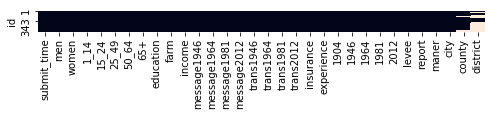

In [5]:
explore_missing_heatmap(questionnaire)

#### Mission 3: Translate into English

In [6]:
questionnaire_eng = questionnaire.copy()

# education
education_map = {
    '本科及以上': 'Higher',
    '大专': 'Higher',
    '高中或中专': 'Basic',
    '初中': 'Basic',
    '小学': 'Basic',
    '小学以下': 'Uneducated'
}
questionnaire_eng['education'] = questionnaire['education'].map(education_map)

# farm
questionnaire_eng['farm'] = questionnaire['farm'].map({"务农": True, "非农": False})


# messages
message_map = {
    '固定电话': 'fixed telephone',
    '移动电话': 'mobile phone',
    '互联网': 'network',
    '尚无': 'null'
}
for year in MAJOR_HISTORICAL_FLOODS[1:]:
    col = 'message{}'.format(year)
    questionnaire_eng[col] = questionnaire[col].replace(message_map, regex=True)

# transport
transport_map = {
    '自行车': 'bycycle',
    '摩托车': 'motor',
    '汽车': 'car',
    '尚无': 'null'
}
for year in MAJOR_HISTORICAL_FLOODS[1:]:
    col = 'trans' + str(year)
    questionnaire_eng[col] = questionnaire[col].replace(transport_map, regex=True)
    
# insurance
questionnaire_eng['insurance'] = questionnaire['insurance'].map({'有': True, '无': False})

# experience
experience_map = {
    '洪灾': 'flooding',
    '涝灾': 'inundation',
    '尚无': 'null'
}
questionnaire_eng['experience'] = questionnaire['experience'].replace(experience_map, regex=True)

# memory
memory_map = {
    '毫无了解': 'do not know',
    '有所耳闻': 'heard of somewhere',
    '周遭经历': 'heard from intimates',
    '书面记载': 'know from written records',
    '亲身经历': 'experienced'
}
for year in MAJOR_HISTORICAL_FLOODS:
    questionnaire_eng[str(year)] = questionnaire[str(year)].replace(memory_map, regex=True)
    
# location code:
location_map = {
    '石嘴山市': 'A',
    '银川市': 'B',
    '吴忠市': 'C',
    '中卫市': 'D',
    '石嘴山市': 'A',
    '银川市': 'B',
    '贺兰县': 'B',
    '永宁县': 'B',
    '吴忠市': 'C',
    '中卫市': 'D',
    '利通区': 'C',
    '中宁县': 'D'
}

questionnaire_eng['location_code'] = questionnaire_eng['city'].replace(location_map, regex=True).str.strip()
questionnaire_eng.replace('元', '', inplace=True, regex=True)
questionnaire_eng.drop(['city', 'district', 'county'], axis='columns', inplace=True)
questionnaire_eng.head()

,submit_time,men,women,1_14,15_24,25_49,50_64,65+,education,farm,...,experience,1904,1946,1964,1981,2012,levee,report,maner,location_code
id,,,,,,,,,,,,,,,,,,,,,
1,2018-02-20 16:23:00,2,2,0,1,2,1,0,Higher,False,...,null,know from written records,know from written records,know from written records,know from written records,know from written records,8,8,8,B
2,2018-02-20 17:14:00,2,1,0,1,2,0,0,Higher,False,...,null,do not know,do not know,do not know,heard from intimates,do not know,6,6,6,A
3,2018-02-20 17:15:00,2,2,0,1,1,2,0,Higher,True,...,null,do not know,do not know,do not know,do not know,do not know,7,7,7,B
4,2018-02-20 19:34:00,1,2,0,1,1,1,0,Higher,False,...,null,do not know,do not know,do not know,do not know,do not know,5,5,7,B
5,2018-02-20 19:35:00,3,1,1,1,2,0,0,Higher,False,...,null,heard of somewhere,heard of somewhere,heard of somewhere,know from written records; heard of somewhere,heard of somewhere; heard from intimates,8,8,7,A


#### Mission 4: Judge which records are invalid

In [7]:
judge_1 = questionnaire_eng.iloc[:, 1: 3].sum(axis='columns') != questionnaire_eng.iloc[:, 3: 8].sum(axis='columns')
judge_2 = questionnaire_eng['1904'] == 'experienced'
judge_3 = questionnaire_eng['message1946'].apply(lambda x: 'network' in x)
judge_4 = questionnaire_eng['message1946'].apply(lambda x: 'mobile phone' in x)

questionnaire_eng['valid'] = True
for judge in [judge_1, judge_2, judge_3, judge_4]:
    questionnaire_eng.loc[judge, 'valid'] = False
    
valid_data = questionnaire_eng[questionnaire_eng['valid']]
valid_data.to_csv('data/valid_data_in_English.csv', encoding='utf8')

explore_sorted_counts(questionnaire_eng['valid'])
valid_rate = questionnaire_eng['valid'].sum()/len(questionnaire_eng)
print("Valid rate of questionnaire dataset is {:.2%}".format(valid_rate))

True     606
False     76
Name: valid, dtype: int64 

There are 0.00% missing values in column "valid".


Valid rate of questionnaire dataset is 88.86%


In [8]:
valid_data.head()

,submit_time,men,women,1_14,15_24,25_49,50_64,65+,education,farm,...,1904,1946,1964,1981,2012,levee,report,maner,location_code,valid
id,,,,,,,,,,,,,,,,,,,,,
1,2018-02-20 16:23:00,2,2,0,1,2,1,0,Higher,False,...,know from written records,know from written records,know from written records,know from written records,know from written records,8,8,8,B,True
2,2018-02-20 17:14:00,2,1,0,1,2,0,0,Higher,False,...,do not know,do not know,do not know,heard from intimates,do not know,6,6,6,A,True
3,2018-02-20 17:15:00,2,2,0,1,1,2,0,Higher,True,...,do not know,do not know,do not know,do not know,do not know,7,7,7,B,True
4,2018-02-20 19:34:00,1,2,0,1,1,1,0,Higher,False,...,do not know,do not know,do not know,do not know,do not know,5,5,7,B,True
5,2018-02-20 19:35:00,3,1,1,1,2,0,0,Higher,False,...,heard of somewhere,heard of somewhere,heard of somewhere,know from written records; heard of somewhere,heard of somewhere; heard from intimates,8,8,7,A,True
